In [1]:
import math
import numpy as np
from numpy import random
from matplotlib import pyplot as plt
from matplotlib import image
from urllib.request import urlopen
from PIL import Image

# A simple example

To motivate the introduction of gradient descent with momentum, compared to plain gradient descent, we discuss a very simple example. Let us consider
\begin{equation*}
f : (x_1,x_2)\in\mathbb{R}^2 \to \frac{1}{2} \left(\lambda_1 x_1^2 + \lambda_2 x_2^2\right),
\end{equation*}
for parameters $0 < \lambda_1 < \lambda_2$.

This function is convex, $\lambda_1$-strongly convex, and $\lambda_2$-smooth.

In [2]:
def f(lambda1,lambda2,x): return 0.5*(lambda1 * x[0]**2 + lambda2 * x[1]**2)

**Question 1:** Compute the gradient of $f$.

**Answer 1:** For all $(x_1,x_2)\in\mathbb{R}^2$, $\nabla f(x_1,x_2) = (\lambda_1 x_1, \lambda_2 x_2)$.

**Question 2:** Write a function grad_f which takes as input $\lambda_1,\lambda_2,x=(x_1,x_2)$, and computes the gradient of $f$ at $x$ (and returns it as a Numpy array).

In [3]:
def grad_f(lambda1,lambda2,x):
    return np.array([lambda1 * x[0], lambda2 * x[1]])

The following function implements plain gradient descent. It takes as input:
* a function $f:\mathbb{R}^n \to \mathbb{R}$,
* its gradient $grad:\mathbb{R}^n \to \mathbb{R}^n$,
* an initial point $x_0 \in \mathbb{R}^n$,
* a number of iterations $T$,
* a stepsize step.

It returns the list of gradient descent iterates, as well as the list of objective values.

In [4]:
def gradient_descent(f,grad,x0,T,step):
    
    print('Running gradient descent')
    
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    iterates[:,0] = x0
    vals[0] = f(x0)
    
    x = x0
    for t in range(1,T+1):
        # Descent step
        x = x - step * grad(x)
        # Record
        iterates[:,t] = x
        vals[t] = f(x)
        
    print('Final value: ',vals[T])
    
    return (iterates,vals)

Let us run gradient descent on our function $f: (x_1,x_2) \to \frac{1}{2} \left(\lambda_1 x_1^2 + \lambda_2 x_2^2\right)$ for $\lambda_1=0.5,\lambda_2=1$, starting at $x_0=(1,1)$, with stepsize $4/3$.

In [5]:
def plot_iterates_2D(iterates):
    # Display a list of points in R^2
    
    # Plot
    fig, ax = plt.subplots()
    ax.plot(iterates[0,:], iterates[1,:], 'kx-')
    
    # Axes limits
    xmin = min(iterates[0,:])
    xmax = max(iterates[0,:])
    (xmin,xmax) = (1.2*xmin-0.2*xmax,1.2*xmax-0.2*xmin)
    ymin = min(iterates[1,:])
    ymax = max(iterates[1,:])
    (ymin,ymax) = (1.2*ymin-0.2*ymax,1.2*ymax-0.2*ymin)
    ax.set_xlim(xmin=xmin,xmax=xmax)
    ax.set_ylim(ymin=ymin,ymax=ymax)
    
    # Grid
    ax.grid(True)
    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')

Running gradient descent
Final value:  3.642701812214134e-15


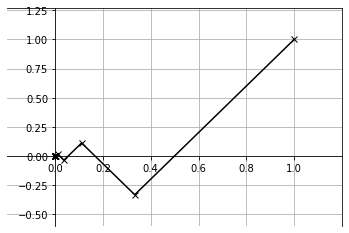

In [6]:
# Define function with parameters lambda1=0.5 and lambda2=1
f1 = lambda x: f(0.5,1,x)
grad_f1 = lambda x:grad_f(0.5,1,x)

(iterates,vals) = gradient_descent(f1,grad_f1,[1,1],15,4/3)
plot_iterates_2D(iterates)

**Question 3:** Same question with $\lambda_1=0.1,\lambda_2=1$. Compare with the previous case. What happens if you use a smaller stepsize? a larger stepsize?

Running gradient descent
Final value:  0.0006831763157243482


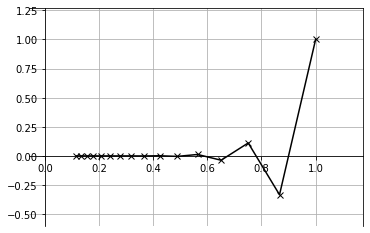

In [7]:
def f2(x): return f(0.1,1,x)
def grad_f2(x): return grad_f(0.1,1,x)

(iterates,vals) = gradient_descent(f2,grad_f2,[1,1],15,4/3)
plot_iterates_2D(iterates)

**Answer 3:** Convergence is still fast along the second coordinate, but much slower along the first one. With a smaller stepsize, convergence is even slower. When the stepsize increases, convergence becomes slightly faster at first, but then, the iterates start to diverge.

We implement gradient descent with (constant) momentum, and run it on the same functions.

**Question 4:** Compare the final objective values.

In [8]:
def gradient_descent_with_momentum(f,grad,x0,T,mu,L):
    # Gradient descent with momentum for mu-strongly convex and L-smooth functions
    
    print('Running heavy ball')
    
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+1))
    vals = np.zeros(T+1)
    iterates[:,0] = x0
    vals[0] = f(x0)
    
    x = x0
    m = grad(x0) # initial momentum
    gamma = (math.sqrt(L)-math.sqrt(mu))**2 / (math.sqrt(L)+math.sqrt(mu))**2 # momentum parameter
    step = 1 / math.sqrt(mu*L)
    for t in range(1,T+1):
        
        m = (1-gamma) * grad(x) + gamma * m # average current momentum and gradient
        x = x - step * m # "gradient" step
        iterates[:,t] = x
        vals[t] = f(x)
        
    print('Final value: ',vals[T])
    
    return (iterates,vals)

Running heavy ball
Final value:  3.4458494367127772e-06


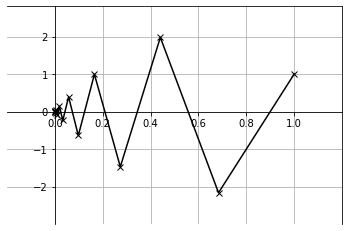

In [9]:
(iterates,vals) = gradient_descent_with_momentum(f2,grad_f2,[1,1],15,0.1,1)
plot_iterates_2D(iterates)

**Answer 4:** Gradient descent with momentum is much faster!

# Quadratic functions

We will now test the algorithms seen during the class on functions in higher dimension than $2$, starting with quadratics. The following function takes as input three parameters $\mu,L,n$. It returns a quadratic function on $\mathbb{R}^n$, which is $\mu$-strongly convex and $L$-smooth, and its gradient.

In [10]:
def generate_quadratic(mu,L,n):
    lambdas = np.random.uniform(mu,L,n) # random choice of eigenvalues
    def f(x):
        return 0.5 * np.sum(lambdas * (x ** 2))
    def grad_f(x):
        return lambdas * x
    return (f,grad_f)

**Question 5:** Fill in the following code, to obtain an implementation of Nesterov, which can run the two variants seen during the class (the one with constant step and momentum parameter, for smooth strongly convex objective functions, and the one which changing parameters, for smooth but not strongly convex objectives).

In [11]:
def nesterov(f,grad,x0,T,strongly_convex,params):
    # f, grad: a function and its gradient
    # x0: starting point
    # T: number of iterations
    # strongly_convex: True -> use Nesterov's method with constant parameters
    #                  False -> use the version for non-strongly convex functions
    # params: (mu,L) if strongly_convex==True
    #                (strong convexity and smoothness parameters)
    #          L     if strongly_convex==False
    #                (smoothness parameter)
    
    n = np.shape(x0)[0]
    
    # Initialize lists of iterates and objective values
    iterates = np.zeros((n,T+2)) # iterates, starting at x_{-1}
    vals = np.zeros(T+1)
    iterates[:,0] = x0 # x_{-1}
    iterates[:,1] = x0 # x_0
    vals[0] = f(x0)
    
    if strongly_convex:
        print('Running Nesterov with constant parameters')
        # Set alpha, beta
        (mu,L) = params
        alpha = 1/L
        beta = (math.sqrt(L)-math.sqrt(mu)) / (math.sqrt(L)+math.sqrt(mu))
    else:
        print('Running Nesterov with changing parameters')
        # Set alpha, initial lambda
        L = params
        alpha = 1/L
        lam = 0
    
    x = x0
    for t in range(1,T+1):
        
        if not strongly_convex:
            # Compute beta and new lambda
            prev_lam = lam
            lam = (1 + math.sqrt(1+4*lam**2)) / 2
            beta = (prev_lam - 1) / lam
        
        # Step
        y = x + beta * (x - iterates[:,t-1])
        x = y - alpha * grad(y)
        iterates[:,t+1] = x
        vals[t] = f(x)
        
    print('Final value: ',vals[T])
    
    return (iterates,vals)

We compare all algorithms on $20$-dimensional moderately ill-conditioned objective functions.

**Question 6:** Run the code several times. Compare and explain the convergence rate of all algorithms.

Running gradient descent
Final value:  2.3423738127822185e-21
Running heavy ball
Final value:  2.1097845376481156e-33
Running Nesterov with constant parameters
Final value:  1.107452628028402e-28
Running Nesterov with changing parameters
Final value:  6.812118235598481e-14


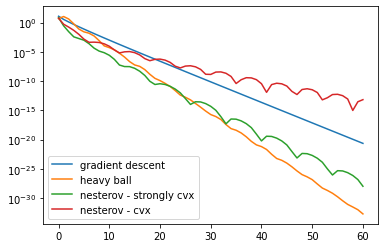

In [12]:
n = 20
nb_its = 60
mu = 0.1
L = 1
(quad,grad_quad) = generate_quadratic(mu,L,n)
plt.yscale("log")
(iterates,vals) = gradient_descent(quad,grad_quad,random.randn(n),nb_its,2/(mu+L))
plt.plot(vals, label="gradient descent")
(iterates,vals) = gradient_descent_with_momentum(quad,grad_quad,random.randn(n),nb_its,mu,L)
plt.plot(vals, label="heavy ball")
(iterates,vals) = nesterov(quad,grad_quad,random.randn(n),nb_its,strongly_convex=True,params=(mu,L))
plt.plot(vals, label="nesterov - strongly cvx")
(iterates,vals) = nesterov(quad,grad_quad,random.randn(n),nb_its,strongly_convex=False,params=L)
plt.plot(vals, label="nesterov - cvx")
plt.legend()

**Answer 6:** Nesterov's method with changing parameters is the only one which does not converge geometrically (it does not take advantage of the strong convexity of the objective). It is thus the slowest algorithm. Gradient descent, heavy ball and Nesterov's method with constant parameters converge geometrically. As expected, gradient descent has the worst convergence rate, and it appears that heavy ball has the best one. However, when the objective function is moderately ill-conditioned, all three algorithms are comparable.

**Question 7:** Same question for $\mu=0.001, L=1$.

Running gradient descent
Final value:  6.468331444444958e-05
Running heavy ball
Final value:  0.2244767990964282
Running Nesterov with constant parameters
Final value:  1.5329826027683596e-05
Running Nesterov with changing parameters
Final value:  2.152777216142708e-06


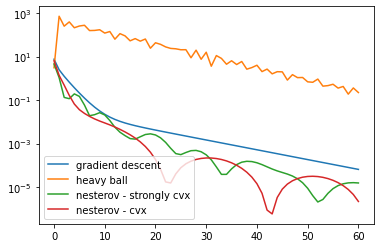

In [13]:
n = 20
nb_its = 60
mu = 0.001
L = 1
(quad,grad_quad) = generate_quadratic(mu,L,n)
plt.yscale("log")
(iterates,vals) = gradient_descent(quad,grad_quad,random.randn(n),nb_its,2/(mu+L))
plt.plot(vals, label="gradient descent")
(iterates,vals) = gradient_descent_with_momentum(quad,grad_quad,random.randn(n),nb_its,mu,L)
plt.plot(vals, label="heavy ball")
(iterates,vals) = nesterov(quad,grad_quad,random.randn(n),nb_its,strongly_convex=True,params=(mu,L))
plt.plot(vals, label="nesterov - strongly cvx")
(iterates,vals) = nesterov(quad,grad_quad,random.randn(n),nb_its,strongly_convex=False,params=L)
plt.plot(vals, label="nesterov - cvx")
plt.legend()

**Answer 7:** Gradient descent, heavy ball and Nesterov's method with constant parameters still have a linear convergence rate, but the decay rate is very close to $1$ because the objective function is severely ill-conditioned. In addition, heavy ball presents a "burn-in" phase during the first iterations, where the objective value significantly increases, before going down. This allows Nesterov's method with changing parameters to be faster than the other algorithms during the first $60$ iterations.

# Image deblurring

In the last part of this notebook, we test our algorithms on a non-quadratic objective function, aiming at solving an image deblurring problem. (Of course, we use a simple function, for the purpose of illustration; much better deblurring results could be obtained with more sophisticated techniques.)

First, we load and display the image we will use for testing. Let $(n_0,n_1)$ be its dimension. It is represented in Python by an $n_0\times n_1$ NumPy array.

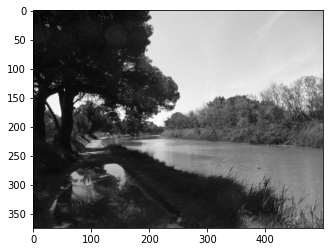

In [14]:
img_color = Image.open(urlopen("https://www.ceremade.dauphine.fr/~waldspurger/tds/22_23_s1/3_robine.PNG"))
img_gray = np.mean(img_color,axis=2)
n0 = img_gray.shape[0]
n1 = img_gray.shape[1]
plt.imshow(img_gray,cmap='gray')

The blurring operator is a linear map $M:\mathbb{R}^{n_0\times n_1} \to \mathbb{R}^{n_0 \times n_1}$, defined by
\begin{equation*}
\forall x\in\mathbb{R}^{n_0\times n_1},\quad
M(x) = x \star \phi,
\end{equation*}
where $\phi$ is a Gaussian filter, and the convolution operator $\star$ is defined as
\begin{equation*}
\forall k<n_0,l<n_1,\quad
x\star \phi[k,l] = \sum_{k'<n_0,l'<n_1} x[k',l'] \phi[k-k',l-l'].
\end{equation*}
(Here, indices are considered modulo $n_0$ along the first dimension, and modulo $n_1$ along the second dimension: $\phi[-1,-1] = \phi[n_0-1,n_1-1]$, for instance.)

Implementations of the map $M$, and its adjoint $M^T$, are provided below. You can use these implementations even if you do not feel comfortable with the definition of $M$.

In [15]:
# Define filter
x0s = [x0 - n0*round(x0/n0) for x0 in range(0,n0)]
x1s = [x1 - n1*round(x1/n1) for x1 in range(0,n1)]
[x1s,x2s] = np.meshgrid(x1s,x0s)
rad = 5
fil = np.exp(-(x1s/rad)**2 - (x2s/rad)**2) / rad**2
# Fourier transform (for a fast computation of convolutions)
fil_fft2 = np.fft.fft2(fil)
conj_fil_fft2 = np.conj(fil_fft2)
# Define blurring operator, and adjoint
def meas_op(M):
    return np.real(np.fft.ifft2(np.fft.fft2(M) * fil_fft2))
def adjoint_op(ym):
    return np.real(np.fft.ifft2(np.fft.fft2(ym) * conj_fil_fft2))

Image deblurring consists in recovering "clean" images from their (noisy) image through the previously defined blurring operator.

We compute the blurred version of our test image.

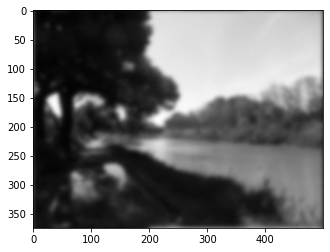

In [16]:
y = meas_op(img_gray)
y = y + 0.01 * np.random.randn(n0,n1) / math.sqrt(n0*n1) * np.linalg.norm(y) # add noise
plt.imshow(y,cmap='gray')

We call $x_{true}$ the image, and $y = M(x_{true}) + \mathrm{noise}$ its blurred version. We propose to recover $x_{true}$ by minimizing the following function:
\begin{equation*}
F:x \in \mathbb{R}^{n_0\times n_1}
\to \frac{1}{2}||M(x)-y||_2^2 + \alpha\left( \sum_{i=1}^{n_0-1}\sum_{j=0}^{n_1-1} |x_{i,j}-x_{i-1,j}|
+ \sum_{i=0}^{n_0-1}\sum_{j=1}^{n_1-1} |x_{i,j}-x_{i,j-1}|\right),
\end{equation*}
where $\alpha>0$ is some parameter which must be adequately chosen.

Intuitively, in the definition of $F$, the first term is a "data fidelity" term: it is small if the blurred version of $x$ is approximately identical to $y$, the blurred version of $x_{true}$. The second term describes a "prior": neighboring pixels in the image must have essentially the same value.

As the absolute value is not differentiable at zero, we replace it with a smooth approximation: for some small $\epsilon>0$, we consider
\begin{equation*}
F_{\epsilon}:x \in \mathbb{R}^{n_0\times n_1}
\to \frac{1}{2}||M(x)-y||_2^2 + \alpha\left( \sum_{i=1}^{n_0-1}\sum_{j=0}^{n_1-1} g_{\epsilon}(x_{i,j}-x_{i-1,j})
+ \sum_{i=0}^{n_0-1}\sum_{j=1}^{n_1-1} g_{\epsilon}(x_{i,j}-x_{i,j-1})\right),
\end{equation*}
where
\begin{equation*}
g_{\epsilon}:t\in\mathbb{R} \to \sqrt{t^2+\epsilon^2} - \epsilon.
\end{equation*}

**Question 8:** Compute the derivative $g_{\epsilon}'$. For $\epsilon=10^{-2}$, implement functions g\_eps and g\_eps\_prime, which apply $g_{\epsilon}$ and $g_{\epsilon}'$ to all elements of a NumPy array.

In [17]:
epsilon = 1e-2
def g_eps(T):
    return np.sqrt(T**2 + epsilon**2) - epsilon
def g_eps_prime(T):
    return T / np.sqrt(T**2 + epsilon**2)

**Question 9:** Define a function f\_eps, which takes as input the parameter $\alpha$ and a vector $x_{vec}\in\mathbb{R}^{n_0n_1}$, reshapes $x_{vec}$ into a NumPy arrray $x$, of size $n_0\times n_1$, and returns $F_{\epsilon}(x)$.

(The function must take as input a vector, and not directly a two-dimensional array, so that it is compatible with our previous implementations of gradient descent, heavy ball, and Nesterov's method, which require a vector as input.)

In [18]:
def f_eps(alpha,x_vec):
    x = np.reshape(x_vec,(n0,n1))
    obj1 = np.linalg.norm(meas_op(x) - y)**2 / 2
    Ti = x[1:,:] - x[0:-1,:]
    Tj = x[:,1:] - x[:,0:-1]
    obj2 = alpha * (np.sum(np.sum(g_eps(Ti))) + np.sum(np.sum(g_eps(Tj))))
    return obj1 + obj2

**Question 10:** Compute $\nabla F_{\epsilon}$. Define a function grad\_f\_eps, which takes $\alpha$ and a vector $x_{vec}$ as input, and returns $\nabla F_{\epsilon}(x)$ (shaped as a vector in $\mathbb{R}^{n_0n_1}$).

**Answer 10:** For any $x\in\mathbb{R}^{n_0\times n_1}$,
\begin{equation*}
\nabla F_{\epsilon}(x) = 
M^T(M(x)-y) + \alpha Z(x),
\end{equation*}
where $Z(x)$ is an $n_0\times n_1$ matrix such that, for any $i,j$,
\begin{align*}
Z(x)_{i,j} & = g_{\epsilon}'(x_{i,j}-x_{i-1,j})1_{i-1\geq 0} - g_{\epsilon}'(x_{i+1,j}-x_{i,j})1_{i+1<n_0} \\
&\qquad + g_{\epsilon}'(x_{i,j}-x_{i,j-1})1_{j-1\geq 0} - g_{\epsilon}'(x_{i,j+1}-x_{i,j})1_{j+1<n_1}.
\end{align*}
(Here, $1_{i-1\geq 0}$ means "$1$ if $i-1\geq 0$, and $0$ if $i-1<0$", and $1_{i+1<n_0},1_{j-1\geq 0},1_{j+1<n_1}$ are defined similarly).

In [19]:
def grad_f_eps(alpha,x_vec):
    x = np.reshape(x_vec,(n0,n1))
    
    grad = adjoint_op(meas_op(x) - y)
    Ti = x[1:,:] - x[0:-1,:]
    Tj = x[:,1:] - x[:,0:-1]
    g_eps_pr_Ti = g_eps_prime(Ti)
    g_eps_pr_Tj = g_eps_prime(Tj)
    grad[1:,:] = grad[1:,:] + alpha * g_eps_pr_Ti
    grad[:-1,:] = grad[:-1,:] - alpha * g_eps_pr_Ti
    grad[:,1:] = grad[:,1:] + alpha * g_eps_pr_Tj
    grad[:,:-1] = grad[:,:-1] - alpha * g_eps_pr_Tj
    
    return np.reshape(grad,n0*n1)

We test the previous two functions: we choose a random $x_{vec}$ and a random $h$ in $\mathbb{R}^{n_0n_1}$. We know that, for small values of $\eta>0$:
\begin{equation*}
\langle \nabla F_{\epsilon}(x_{vec}), h\rangle
\approx \frac{F_{\epsilon}(x_{vec}+\eta h) - F_{\epsilon}(x_{vec})}{\eta},
\end{equation*}
so we check that this approximate equality holds.

(For $\alpha=10^{-2}$ and $\eta=10^{-4}$, the relative difference between left and right-hand side should typically be smaller than $0.1\%$, and it must go to zero if you take $\eta$ to be smaller and smaller. If you do not observe this behavior, you should check your functions f\_eps and grad\_f\_eps.)

In [20]:
alpha = 1e-2
x_vec = np.random.rand(n0*n1)
h = np.random.randn(n0*n1)
eta = 1e-4
print('Empirical derivative: ',(f_eps(alpha,x_vec+eta*h) - f_eps(alpha,x_vec)) / eta)
print('Theoretical derivative: ',np.sum(grad_f_eps(alpha,x_vec) * h))

Empirical derivative:  -665822.9446411133
Theoretical derivative:  -665824.3686052391


**Question 11:** (optional) Show that $F_{\epsilon}$ is $L$-smooth with
\begin{equation*}
L = \max_{\omega_0,\omega_1} |\hat\phi(\omega_0,\omega_1)|^2 +
\frac{8 \alpha}{\epsilon}.
\end{equation*}

**Answer 11:** From the expression of the gradient found at the previous question, we have, for any $x,x'\in\mathbb{R}^{n_0\times n_1}$,
\begin{equation*}
||\nabla F_{\epsilon}(x) - \nabla F_{\epsilon}(x')||
\leq ||M^TM(x-x')|| + \alpha ||Z(x)-Z(x')||.
\end{equation*}

We denote $\hat x$ (resp. $\hat{x}'$) the discrete Fourier transform of $x$ (resp. $x'$): for all $\omega_0=0,\dots,n_0-1$ and $\omega_1=0,\dots,n_1-1$,
\begin{equation*}
\hat x[\omega_0,\omega_1] = \sum_{k=0}^{n_0-1} \sum_{l=0}^{n_1-1} x[k,l] e^{-2\pi i
\left(\frac{\omega_0 k}{n_0} + \frac{\omega_1 l}{n_1}\right)}.
\end{equation*}
Then, using the properties of the discrete Fourier transform and the convolution, and denoting $\tilde{\phi}$ the filter such that $\hat{\tilde{\phi}} = \overline{\hat \phi}$,
\begin{align*}
||M^TM(x-x')||
& = ||(x-x') \star \phi \star \tilde{\phi}|| \\
& = ||(\hat x-\hat x') \hat\phi \hat{\tilde{\phi}} || \\
& = ||(\hat x-\hat x') |\hat\phi|^2|| \\
& \leq \left(\max_{\omega_0,\omega_1} |\hat\phi(\omega_0,\omega_1)|^2\right)
||\hat x-\hat x'||.
\end{align*}

For the other term, we first observe that, for any $s$,
\begin{align*}
|g_{\epsilon}''(s)| =
\left|\frac{\epsilon^2}{(s^2+\epsilon^2)^{3/2}}\right|
\leq \frac{\epsilon^2}{(\epsilon^2)^{3/2}}
=\frac{1}{\epsilon}.
\end{align*}
Therefore, $g_{\epsilon}'$ is $\frac{1}{\epsilon}$-Lipschitz, and
\begin{align*}
\left|\left|\left(
g_{\epsilon}'(x_{i,j}-x_{i-1,j})1_{i-1\geq 0} - 
g_{\epsilon}'(x'_{i,j}-x'_{i-1,j})1_{i-1\geq 0}\right)_{i<n_0,j<n_1}\right|\right|
& \leq \frac{1}{\epsilon} \left|\left|\left(
(x_{i,j}-x_{i-1,j} - x'_{i,j}+x'_{i-1,j})1_{i-1\geq 0}\right)_{i<n_0,j<n_1}\right|\right| \\
& \leq \frac{1}{\epsilon} \left|\left|\left(
(x_{i,j} - x'_{i,j})1_{i-1\geq 0}\right)_{i<n_0,j<n_1}\right|\right|
+ \frac{1}{\epsilon} \left|\left|\left(
(x_{i-1,j} - x'_{i-1,j})1_{i-1\geq 0}\right)_{i<n_0,j<n_1}\right|\right| \\
& \leq \frac{2}{\epsilon} ||x-x'||.
\end{align*}
The same holds true for the three other terms in the definition of $Z$, hence
\begin{equation*}
||Z(x)-Z(x')|| \leq \frac{8}{\epsilon} ||x-x'||.
\end{equation*}

If we combine all the previous inequalities, we obtain that, for any $x,x'\in\mathbb{R}^{n_0\times n_1}$,
\begin{equation*}
||\nabla F_{\epsilon}(x) - \nabla F_{\epsilon}(x')||
\leq \left(\max_{\omega_0,\omega_1} |\hat\phi(\omega_0,\omega_1)|^2 
+ \frac{8\alpha}{\epsilon} \right)
||x-x'||.
\end{equation*}

### Results

It can be shown, on the other hand, that $F_{\epsilon}$ is not strongly convex (more precisely, it is strongly convex, but the strong convexity constant is so small that it does not help convergence).

We run our algorithms and plot the results.

Note that heavy ball and Nesterov's method with constant parameters are, strictly speaking, not applicable: in principle, they only work on strongly convex functions. To run them, we provide them "fake" strong convexity parameters. In this setting, it gives good results, but we had no a priori guarantee that this would be the case.

Running gradient descent
Final value:  4051125.60220276
Running heavy ball
Final value:  1848125.1873633065
Running Nesterov with constant parameters
Final value:  1963415.925528355
Running Nesterov with changing parameters
Final value:  1757570.070326185


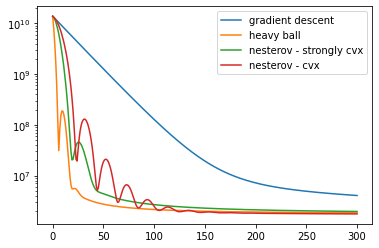

In [21]:
nb_its = 300
alpha = 0.5
f_im = lambda x: f_eps(alpha,x)
grad_f_im = lambda x: grad_f_eps(alpha,x)

L = (np.max(np.abs(fil_fft2)))**2 + 8 / epsilon * alpha
im_init = random.rand(n0*n1)
plt.yscale("log")
(iterates_gd,vals_gd) = gradient_descent(f_im,grad_f_im,im_init,nb_its,1/L)
plt.plot(vals_gd, label="gradient descent")
(iterates_hb,vals_hb) = gradient_descent_with_momentum(f_im,grad_f_im,im_init,nb_its,L/100,L)
plt.plot(vals_hb, label="heavy ball")
(iterates_ne_sc,vals_ne_sc) = nesterov(f_im,grad_f_im,im_init,nb_its,strongly_convex=True,params=(L/100,L))
plt.plot(vals_ne_sc, label="nesterov - strongly cvx")
(iterates_ne,vals_ne) = nesterov(f_im,grad_f_im,im_init,nb_its,strongly_convex=False,params=L)
plt.plot(vals_ne, label="nesterov - cvx")
plt.legend()

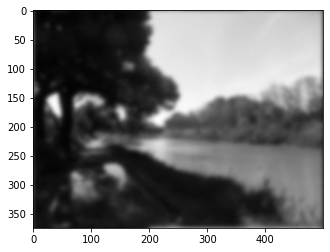

In [22]:
plt.imshow(y,cmap='gray')

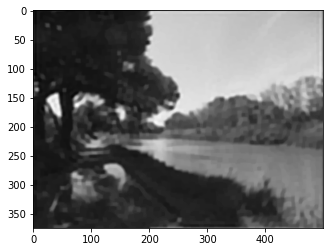

In [23]:
plt.imshow(np.reshape(iterates_ne[:,-1],(n0,n1)),cmap='gray')